In [1]:
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [13]:
from processing_functions import create_df

df_main = create_df(timeFramesUsedInMinutes=["5"], instrument="ES", 
                    start_date = "2023-03-24 12:00", end_date = "2025-02-14 12:00") 

In [15]:
df_main["ATR"].describe()

count    134052.000000
mean          2.812027
std           2.076289
min           0.410714
25%           1.357143
50%           2.160714
75%           3.660714
max          29.357143
Name: ATR, dtype: float64

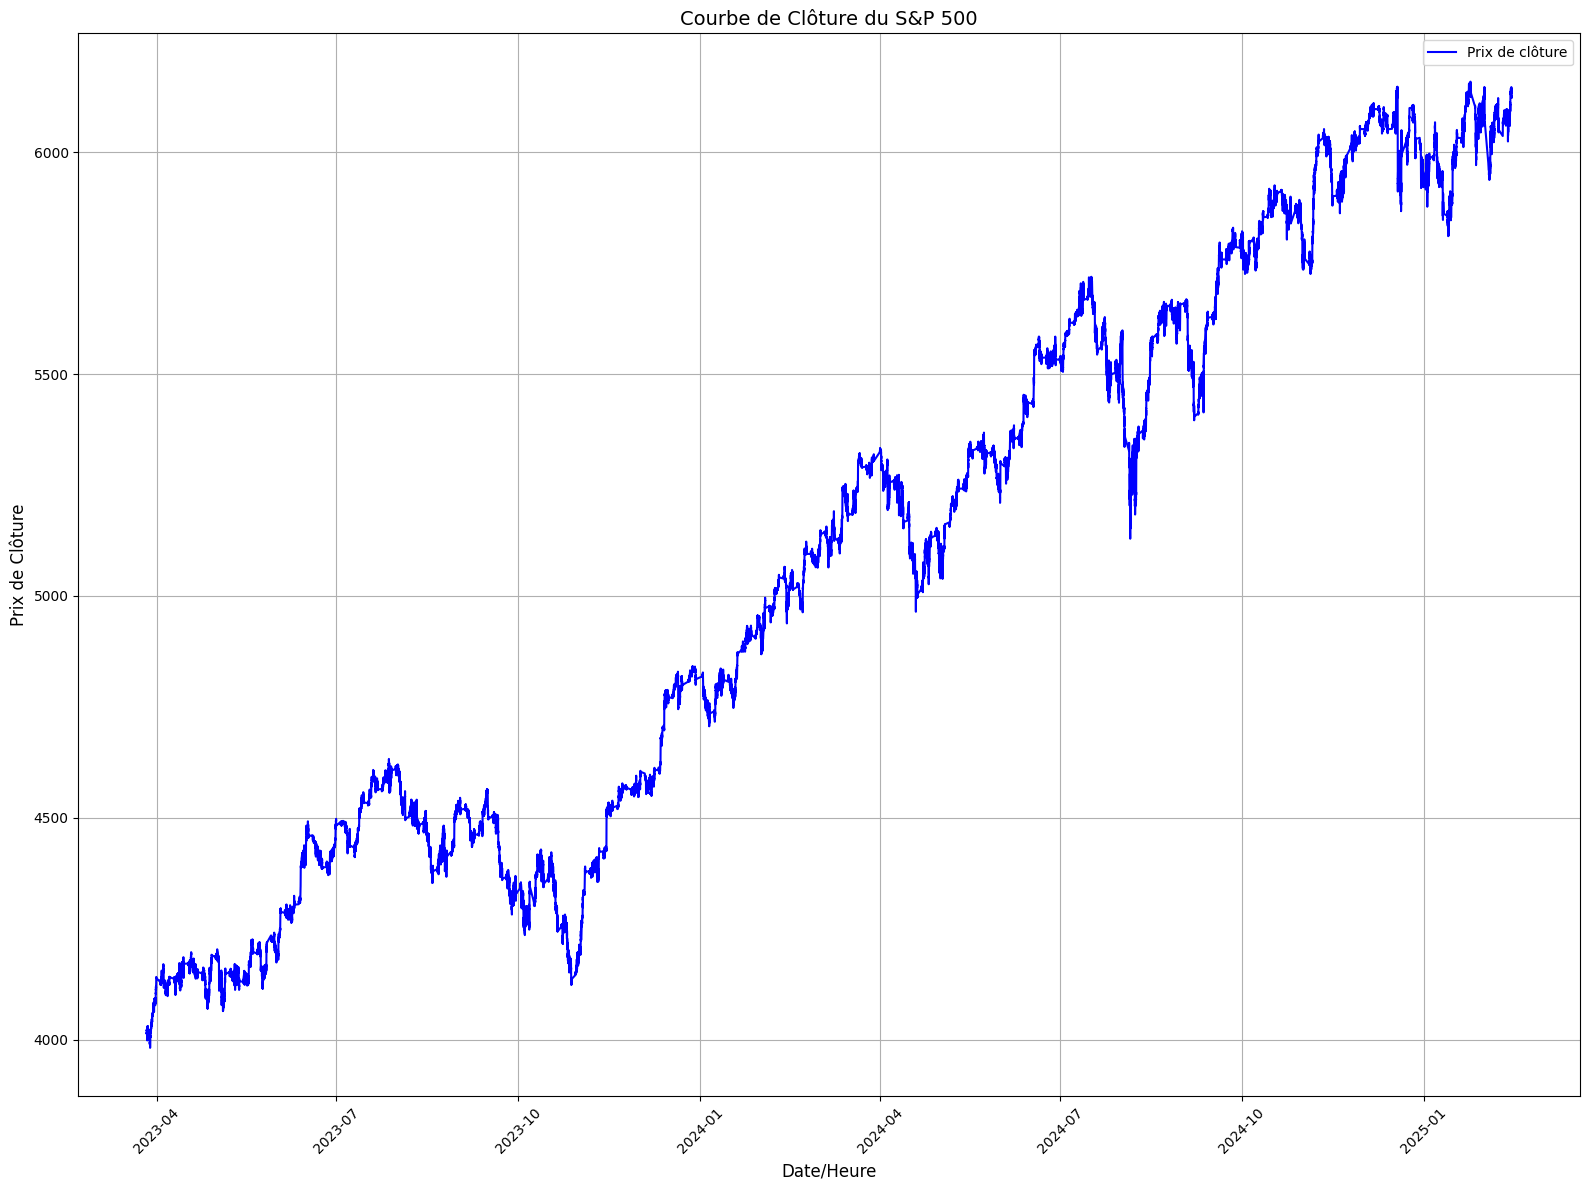

In [ ]:

import matplotlib.pyplot as plt 
plt.figure(figsize=(16,12))
plt.plot(df_main['datetime'], df_main['close'], label='Prix de clôture', color='b')
plt.title('Courbe de Clôture du S&P 500', fontsize=14)
plt.xlabel('Date/Heure', fontsize=12)
plt.ylabel('Prix de Clôture', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

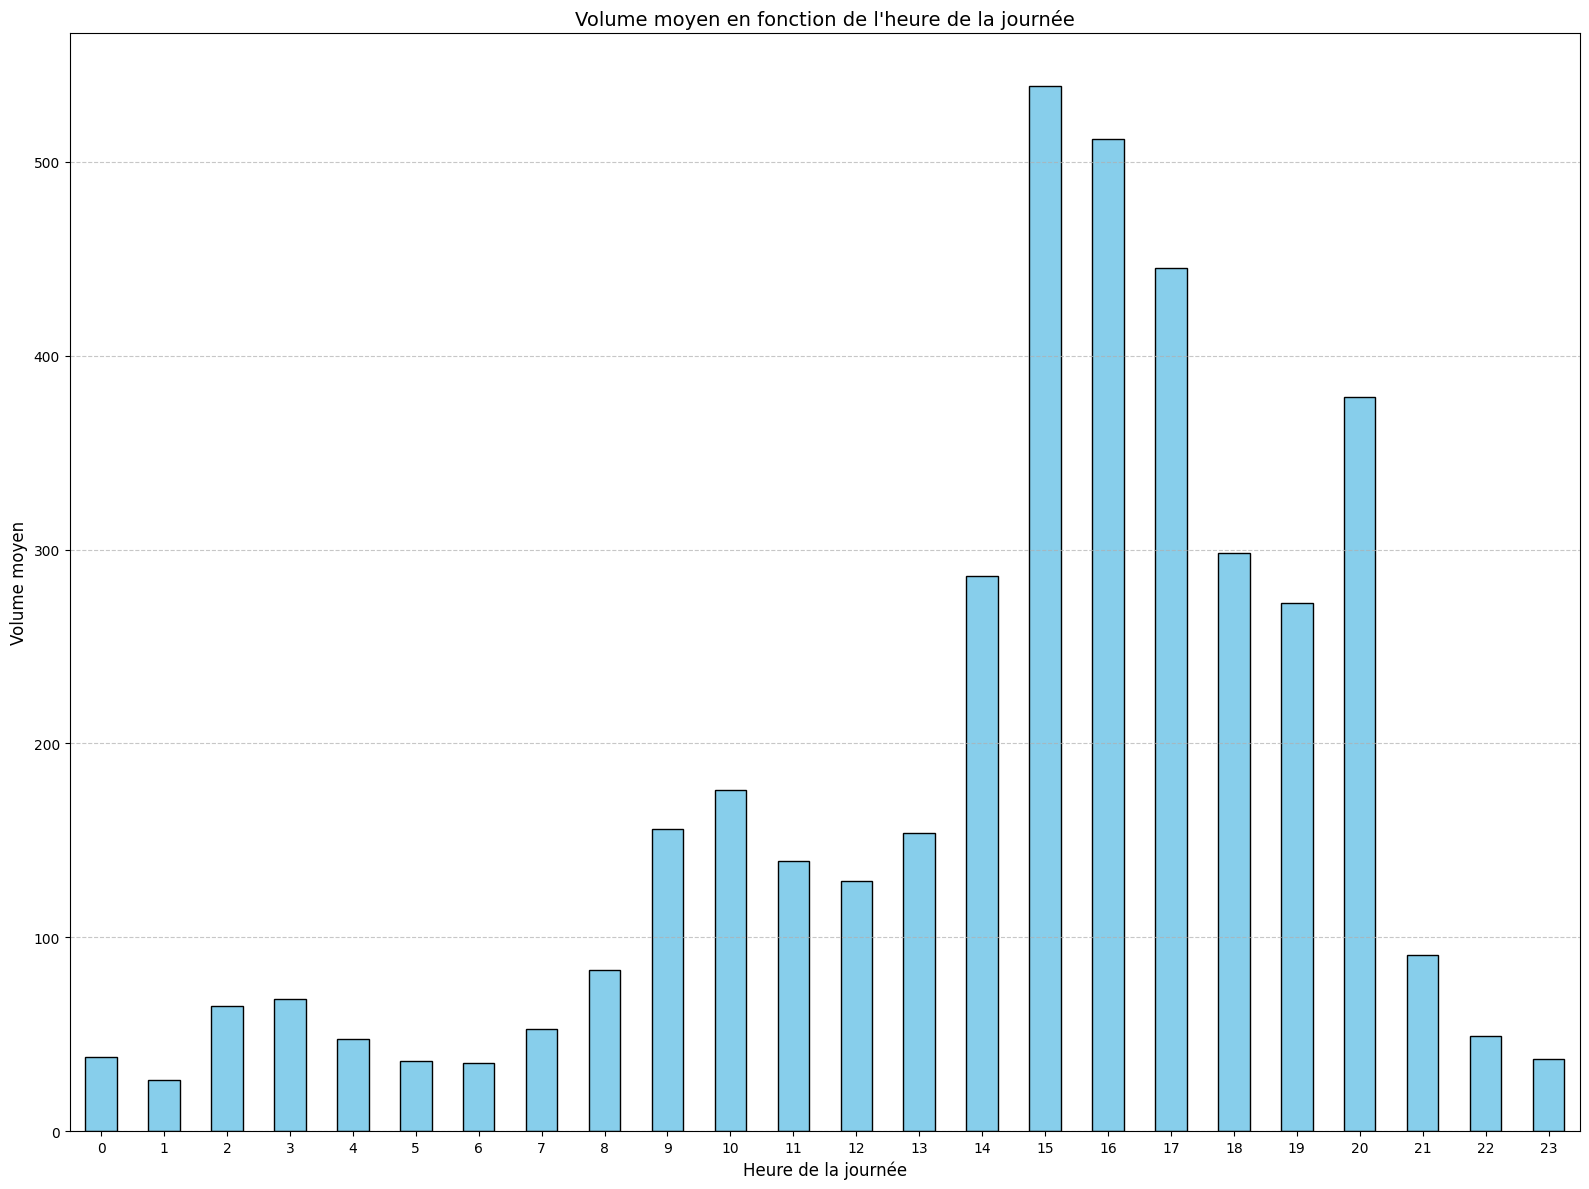

In [3]:

# Extraire l'heure de la journée à partir de 'timestamp'
df_main['hour'] = df_main['datetime'].dt.hour

# Calculer le volume moyen pour chaque heure
volume_moyen_par_heure = df_main.groupby('hour')['volume'].mean()

# Affichage des résultats sous forme d'histogramme
plt.figure(figsize=(16, 12))
volume_moyen_par_heure.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Volume moyen en fonction de l\'heure de la journée', fontsize=14)
plt.xlabel('Heure de la journée', fontsize=12)
plt.ylabel('Volume moyen', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher l'histogramme
plt.tight_layout()
plt.show()

In [1]:
from processing_functions import return_trade_datas_dataframe

filename = "size=1_timeframe=[[1]]_slInTicks=[[50, 70], [40, 70]]_tpInTicks=[[25, 70]]_KijunExitMethod=[1]_"\
    "slModifiers=[[[0.6, 0.15]], [[0.5, 0.12], [0.7, 0.2]], []]_xRatio=[0, 8]"

filepath = f"ES/[2023-03-24 12-00]_[2025-02-14 12-00]/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,tenkanCond,slModifiers,forbbiden Hours,xRatio,stopMethodsForKijunExitExit,US_session_only,ticksCrossed
12,47.567,-166.58,-302.26,0.067,-0.043,0.96,"(15817, 17435, 14524)",2.8,2.9,"(40, 25, 70, 70)",0 days 00:00:20,0 days 00:00:30,[1],2,[],[],8,1,False,0
9,47.586,-165.02,-300.69,0.067,-0.043,0.96,"(15821, 17426, 14524)",2.8,2.9,"(50, 25, 70, 70)",0 days 00:00:20,0 days 00:00:30,[1],2,[],[],8,1,False,0
10,47.629,-88.85,-224.56,0.072,-0.043,0.95,"(15842, 17419, 14525)",2.8,2.9,"(40, 25, 70, 70)",0 days 00:00:20,0 days 00:00:30,[1],2,"[[0.6, 0.15]]",[],8,1,False,0
7,47.650,-62.08,-197.78,0.073,-0.042,0.95,"(15847, 17410, 14525)",2.8,2.9,"(50, 25, 70, 70)",0 days 00:00:20,0 days 00:00:30,[1],2,"[[0.6, 0.15]]",[],8,1,False,0
11,47.717,40.02,-95.74,0.079,-0.042,0.94,"(15883, 17403, 14517)",2.7,2.9,"(40, 25, 70, 70)",0 days 00:00:20,0 days 00:00:30,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],8,1,False,0
6,89.138,-9.78,-49.23,0.128,-1.081,0.12,"(12384, 1509, 0)",5.2,43.1,"(40, 25, 70, 70)",0 days 00:05:30,0 days 00:15:00,[1],2,[],[],0,1,False,0
8,47.736,102.15,-33.60,0.083,-0.042,0.94,"(15888, 17395, 14517)",2.7,2.9,"(50, 25, 70, 70)",0 days 00:00:20,0 days 00:00:30,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],8,1,False,0
3,90.881,23.47,-12.81,0.130,-1.302,0.10,"(11611, 1165, 0)",5.3,52.0,"(50, 25, 70, 70)",0 days 00:05:30,0 days 00:15:50,[1],2,[],[],0,1,False,0
4,89.373,332.78,293.01,0.152,-1.081,0.12,"(12514, 1488, 0)",5.1,43.1,"(40, 25, 70, 70)",0 days 00:05:20,0 days 00:14:40,[1],2,"[[0.6, 0.15]]",[],0,1,False,0
1,91.112,458.35,421.77,0.163,-1.302,0.10,"(11737, 1145, 0)",5.2,52.0,"(50, 25, 70, 70)",0 days 00:05:20,0 days 00:15:30,[1],2,"[[0.6, 0.15]]",[],0,1,False,0


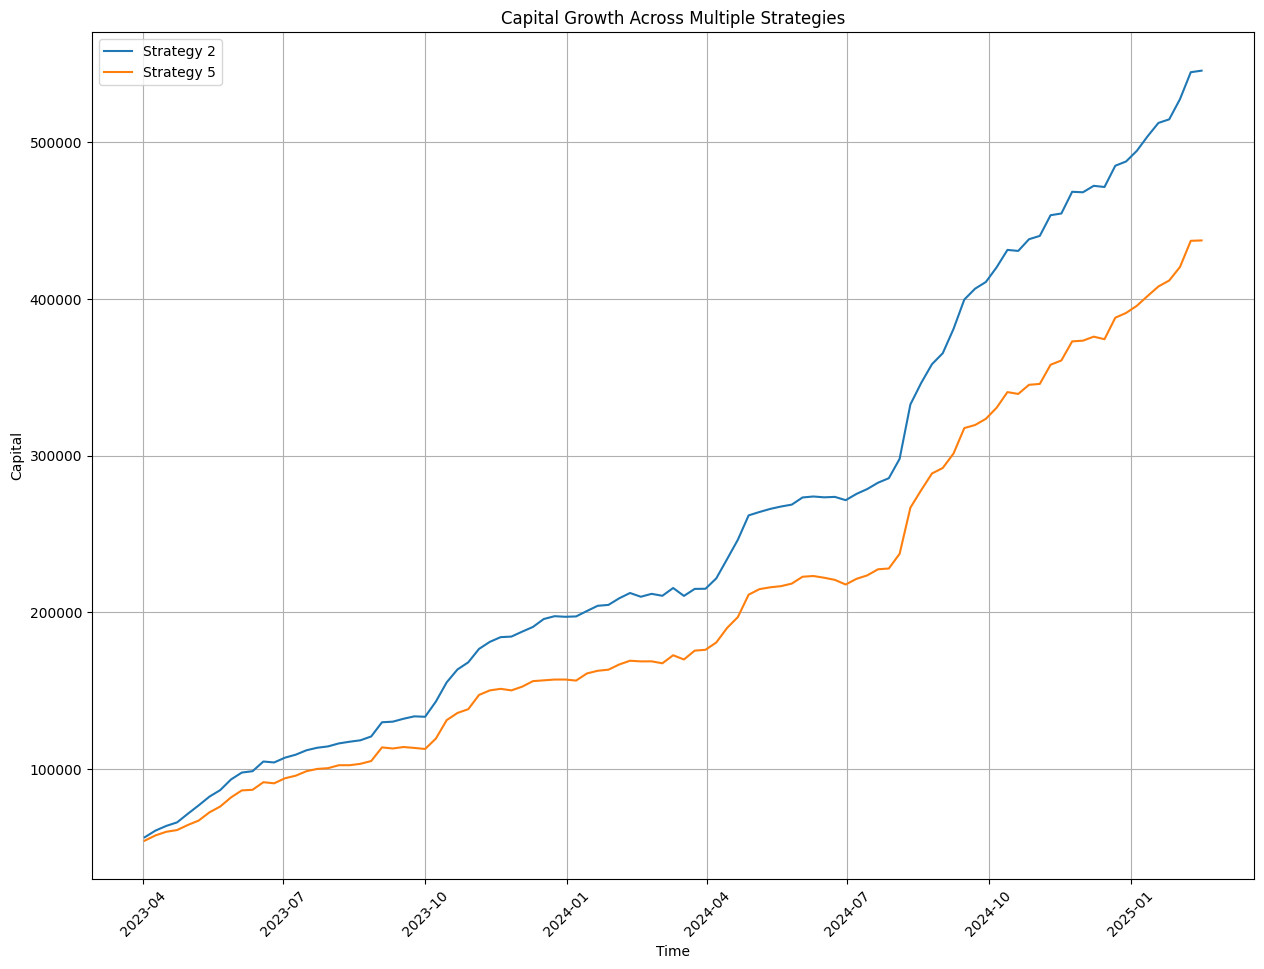

In [2]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+filepath,
                             plotAllDatas=False, dataIdsSelected=[2,5],
                             plotSize=(15,11))

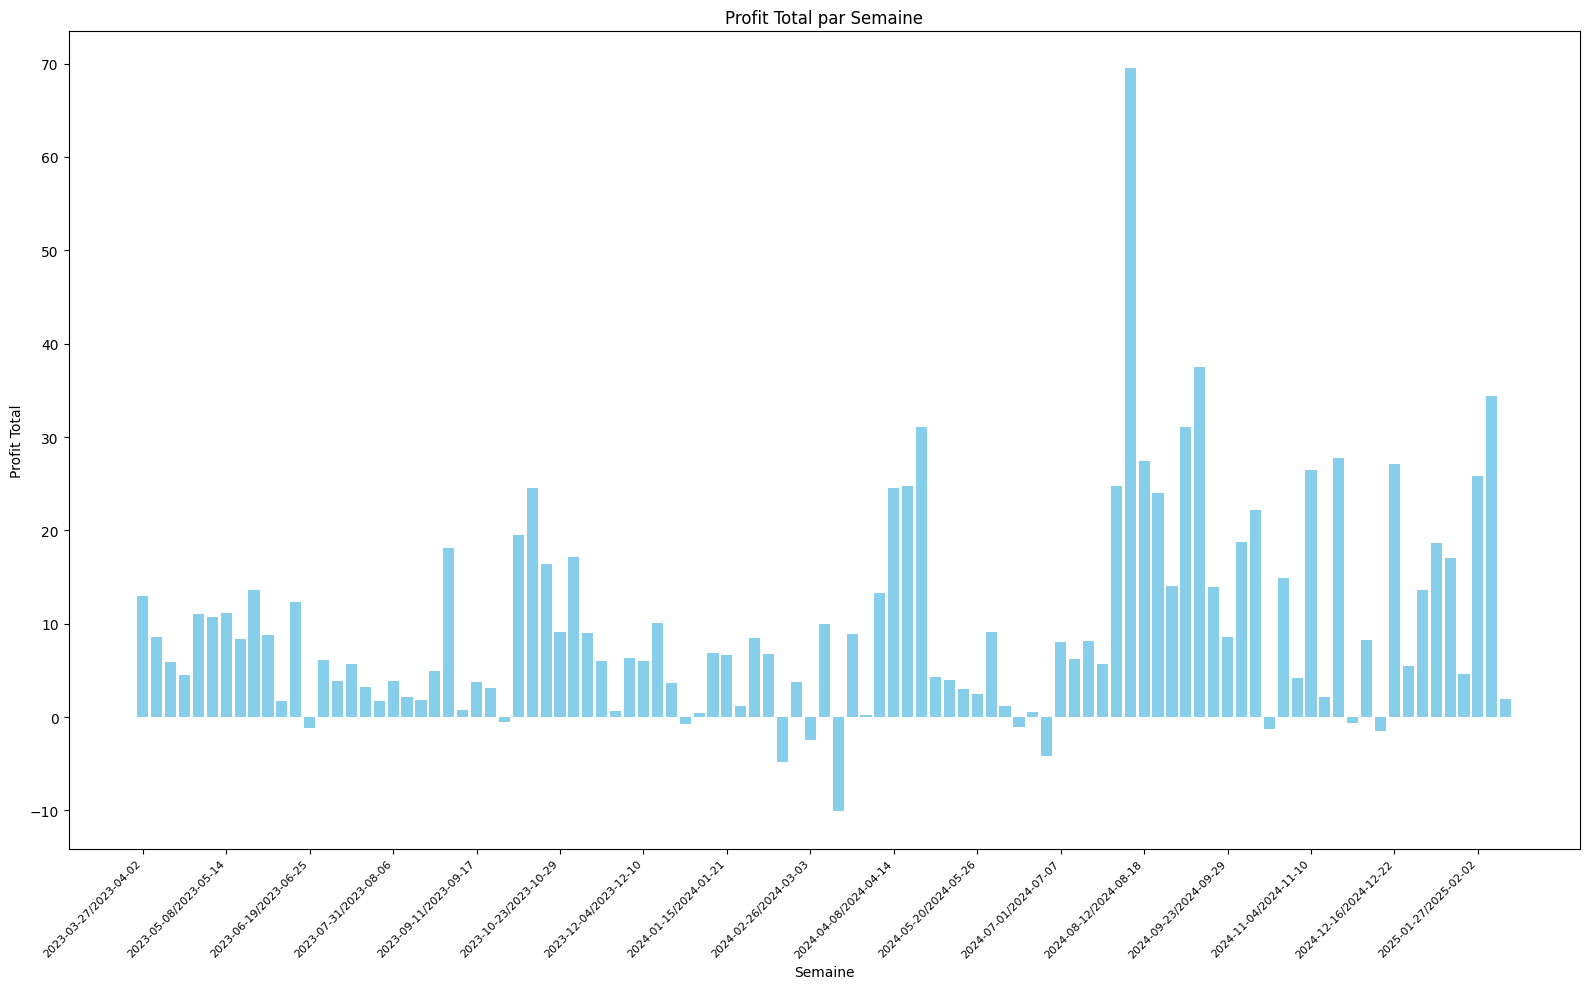

In [3]:
from processing_functions import plot_bars_of_profit_for_every_weeks
plot_bars_of_profit_for_every_weeks(filepath, 2)

### TRY WITH US CALENDAR EVENTS ###

In [ ]:
from processing_functions import return_trade_datas_dataframe

filename = "size=1_timeframe=[[1]]_slInTicks=[[50, 70]]_tpInTicks=[[25, 70]]_KijunExitMethod=[1]_slModifiers=[[[0.5, 0.12], [0.7, 0.2]]]_usCalendar"

filepath = f"ES/[2023-03-24 12-00]_[2025-02-14 12-00]/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated 

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,tenkanCond,slModifiers,forbbiden Hours,calendar_event,stopMethodsForKijunExitExit,US_session_only,ticksCrossed
6,91.366,968.02,931.35,0.202,-1.302,0.1,"(11799, 1115, 0)",5.0,52.0,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:10,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],Unemployment,1,False,0
7,91.317,974.08,937.31,0.203,-1.303,0.1,"(11821, 1124, 0)",5.0,52.0,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],PMI,1,False,0
8,91.326,979.10,942.30,0.203,-1.302,0.1,"(11835, 1124, 0)",5.0,52.0,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],Employment,1,False,0
1,91.337,988.30,951.42,0.204,-1.302,0.1,"(11862, 1125, 0)",5.0,52.0,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:10,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],CPI,1,False,0
2,91.323,989.68,952.79,0.204,-1.302,0.1,"(11862, 1127, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],PPI,1,False,0
5,91.338,992.08,955.16,0.204,-1.302,0.1,"(11874, 1126, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],PCE,1,False,0
4,91.348,993.02,956.16,0.204,-1.300,0.1,"(11856, 1123, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],FOMC,1,False,0
3,91.346,994.30,957.45,0.204,-1.300,0.1,"(11853, 1123, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:10,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],Fed,1,False,0


In [1]:
from processing_functions import return_trade_datas_dataframe

filename = "size=1_timeframe=[[1]]_slInTicks=[[50, 70]]_tpInTicks=[[25, 70]]_KijunExitMethod=[1]_slModifiers=[[[0.5, 0.12], [0.7, 0.2]]]_usCalendar"

filepath = f"ES/[2023-03-24 12-00]_[2025-02-14 12-00]/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,tenkanCond,slModifiers,forbbiden Hours,calendar_event,stopMethodsForKijunExitExit,US_session_only,ticksCrossed
1,91.358,986.78,950.10,0.204,-1.301,0.1,"(11798, 1116, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:10,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],"[CPI, PPI, Fed, FOMC, PCE]",1,False,0
2,91.354,992.15,955.36,0.204,-1.301,0.1,"(11834, 1120, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:10,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],"[Fed, FOMC, PCE]",1,False,0


In [4]:
from processing_functions import return_trade_datas_dataframe

filename = "size=1_timeframe=[[1]]_slInTicks=[[50, 70]]_tpInTicks=[[25, 70]]_KijunExitMethod=[1]_slModifiers=[[[0.5, 0.12], [0.7, 0.2]]]_withATRforTP"

filepath = f"ES/[2023-03-24 12-00]_[2025-02-14 12-00]/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated[tradeDatasFormated["atrRatioForTp"]==0]

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,slModifiers,atrRatioForTp,atrSlopeTreshold,tpToMoveInTicks
6,91.328,991.52,954.59,0.204,-1.301,0.1,"(11879, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0,0.7,6
12,91.328,991.67,954.74,0.204,-1.301,0.1,"(11879, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0,0.9,10
10,91.328,991.67,954.74,0.204,-1.301,0.1,"(11879, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0,0.9,6
11,91.328,991.67,954.74,0.204,-1.301,0.1,"(11879, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0,0.9,8
15,91.328,991.67,954.74,0.204,-1.301,0.1,"(11879, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0,1.1,8
14,91.328,991.67,954.74,0.204,-1.301,0.1,"(11879, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0,1.1,6
16,91.328,991.67,954.74,0.204,-1.301,0.1,"(11879, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0,1.1,10
9,91.328,992.30,955.36,0.204,-1.301,0.1,"(11880, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0,0.9,4
5,91.328,992.30,955.36,0.204,-1.301,0.1,"(11880, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0,0.7,4
13,91.328,992.30,955.36,0.204,-1.301,0.1,"(11880, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0,1.1,4


In [1]:
from processing_functions import return_trade_datas_dataframe

filename = "size=1_timeframe=[[1]]_slInTicks=[[50, 70]]_tpInTicks=[[25, 70]]_KijunExitMethod=[1]_slModifiers=[[[0.5, 0.12], [0.7, 0.2]]]_withATRforTP2"

filepath = f"ES/[2023-03-24 12-00]_[2025-02-14 12-00]/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,slModifiers,percentHitToMoveTP,atrRatioForTp,atrSlopeTreshold,tpToMoveInTicks
63,91.328,22.64,-14.29,0.122,-1.301,0.1,"(11879, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.9,0,1.1,6
47,91.328,22.79,-14.14,0.122,-1.301,0.1,"(11879, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.8,0,1.1,6
59,91.328,22.79,-14.14,0.122,-1.301,0.1,"(11879, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.9,0,0.9,6
64,91.328,22.87,-14.07,0.122,-1.301,0.1,"(11879, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.9,0,1.1,9
31,91.328,22.94,-13.99,0.122,-1.301,0.1,"(11879, 1128, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.7,0,1.1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,91.335,29.26,-7.67,0.123,-1.302,0.1,"(11880, 1127, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:05,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.6,0,0.5,3
20,91.334,29.26,-7.67,0.123,-1.302,0.1,"(11878, 1127, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:10,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.7,0,0.5,9
36,91.334,29.46,-7.47,0.123,-1.302,0.1,"(11878, 1127, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:10,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.8,0,0.5,9
3,91.334,30.16,-6.77,0.123,-1.302,0.1,"(11878, 1127, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:10,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.6,0,0.5,6


In [2]:
from processing_functions import return_trade_datas_dataframe

filename = "size=1_timeframe=[[1]]_slInTicks=[[50, 70]]_tpInTicks=[[25, 70]]_KijunExitMethod=[1]_slModifiers=[[[0.5, 0.12], [0.7, 0.2]]]_withATRforTP3"

filepath = f"ES/[2023-03-24 12-00]_[2025-02-14 12-00]/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,slModifiers,percentHitToMoveTP,atrRatioForTp,atrSlopeTreshold,tpToMoveInTicks
2,91.049,-27.70,-69.99,0.123,-1.304,0.10,"(13559, 1333, 1)",5.0,52.1,"(50, 25, 70, 70)",0 days 00:06:00,0 days 00:16:40,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.6,8,0.3,9
1,91.033,-27.41,-69.66,0.124,-1.304,0.10,"(13542, 1334, 1)",5.1,52.1,"(50, 25, 70, 70)",0 days 00:06:00,0 days 00:16:40,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.6,8,0.3,6
4,91.038,-27.14,-69.38,0.123,-1.304,0.10,"(13541, 1333, 1)",5.1,52.1,"(50, 25, 70, 70)",0 days 00:05:50,0 days 00:16:30,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.6,8,0.5,9
3,91.039,-26.45,-68.70,0.124,-1.304,0.10,"(13543, 1333, 1)",5.1,52.1,"(50, 25, 70, 70)",0 days 00:05:50,0 days 00:16:30,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.6,8,0.5,6
6,91.495,-0.46,-36.66,0.118,-1.306,0.09,"(11661, 1084, 0)",4.8,52.1,"(50, 25, 70, 70)",0 days 00:06:20,0 days 00:17:30,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.6,16,0.3,9
5,91.495,0.05,-36.15,0.118,-1.306,0.09,"(11662, 1084, 0)",4.8,52.1,"(50, 25, 70, 70)",0 days 00:06:20,0 days 00:17:20,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.6,16,0.3,6
8,91.495,0.08,-36.11,0.118,-1.306,0.09,"(11661, 1084, 0)",4.8,52.1,"(50, 25, 70, 70)",0 days 00:06:20,0 days 00:17:20,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.6,16,0.5,9
7,91.495,1.98,-34.21,0.118,-1.306,0.09,"(11661, 1084, 0)",4.9,52.1,"(50, 25, 70, 70)",0 days 00:06:20,0 days 00:17:20,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.6,16,0.5,6
11,92.293,42.54,12.06,0.110,-1.303,0.09,"(9903, 827, 2)",4.5,52.1,"(50, 25, 70, 70)",0 days 00:06:00,0 days 00:17:10,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.6,24,0.5,6
12,92.293,44.03,13.55,0.110,-1.303,0.09,"(9903, 827, 2)",4.5,52.1,"(50, 25, 70, 70)",0 days 00:06:00,0 days 00:17:10,[1],"[[0.5, 0.12], [0.7, 0.2]]",0.6,24,0.5,9


In [3]:
from processing_functions import return_trade_datas_dataframe

filename = "size=1_timeframe=[[5]]_slInTicks=[[50, 70]]_tpInTicks=[[25, 70]]_KijunExitMethod=[1]_slModifiers=[[[0.5, 0.12], [0.7, 0.2]]]_withATRforTP4"

filepath = f"ES/[2023-03-24 12-00]_[2025-02-14 12-00]/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated.tail(60) #[tradeDatasFormated["atrRatioForTp"]>0].iloc[-80:-50]

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,slModifiers,percentHitToMoveTP,atrRatioForTp,atrRatioForSl,atrSlopeTreshold,tpToMoveInTicks
193,86.498,-5.21,-8.47,0.303,-1.968,0.15,"(993, 155, 2)",12.2,79.6,"(50, 25, 70, 70)",0 days 00:30:00,0 days 01:45:00,[5],"[[0.5, 0.12], [0.7, 0.2]]",0.6,0,8,0.3,0
196,86.498,-5.21,-8.47,0.303,-1.968,0.15,"(993, 155, 2)",12.2,79.6,"(50, 25, 70, 70)",0 days 00:30:00,0 days 01:45:00,[5],"[[0.5, 0.12], [0.7, 0.2]]",0.6,0,8,0.5,0
217,86.498,-5.21,-8.47,0.303,-1.968,0.15,"(993, 155, 2)",12.2,79.6,"(50, 25, 70, 70)",0 days 00:30:00,0 days 01:45:00,[5],"[[0.5, 0.12], [0.7, 0.2]]",0.8,0,8,0.3,0
220,86.498,-5.21,-8.47,0.303,-1.968,0.15,"(993, 155, 2)",12.2,79.6,"(50, 25, 70, 70)",0 days 00:30:00,0 days 01:45:00,[5],"[[0.5, 0.12], [0.7, 0.2]]",0.8,0,8,0.5,0
222,86.486,-5.17,-8.43,0.303,-1.968,0.15,"(992, 155, 2)",12.2,79.6,"(50, 25, 70, 70)",0 days 00:30:00,0 days 01:45:00,[5],"[[0.5, 0.12], [0.7, 0.2]]",0.8,0,8,0.5,12
68,60.359,-6.99,-8.41,0.429,-0.696,0.62,"(303, 199, 0)",17.3,27.7,"(50, 25, 70, 70)",0 days 00:40:00,0 days 01:45:00,[5],"[[0.5, 0.12], [0.7, 0.2]]",0.6,7,3,0.3,8
194,86.538,-5.14,-8.39,0.302,-1.971,0.15,"(990, 154, 2)",12.2,79.7,"(50, 25, 70, 70)",0 days 00:30:00,0 days 01:45:00,[5],"[[0.5, 0.12], [0.7, 0.2]]",0.6,0,8,0.3,8
93,60.359,-6.92,-8.34,0.429,-0.696,0.62,"(303, 199, 0)",17.3,27.7,"(50, 25, 70, 70)",0 days 00:40:00,0 days 01:45:00,[5],"[[0.5, 0.12], [0.7, 0.2]]",0.8,7,3,0.3,12
50,75.154,-4.28,-7.96,0.295,-0.911,0.33,"(974, 322, 2)",11.9,36.6,"(50, 25, 70, 70)",0 days 00:25:00,0 days 00:55:00,[5],"[[0.5, 0.12], [0.7, 0.2]]",0.6,0,3,0.3,8
47,73.556,-6.33,-7.61,0.429,-1.258,0.34,"(331, 119, 0)",17.3,50.2,"(50, 25, 70, 70)",0 days 01:20:00,0 days 02:40:00,[5],"[[0.5, 0.12], [0.7, 0.2]]",0.8,7,0,0.5,8


In [ ]:
# normal result : 91.328	991.68	954.73	0.204	-1.301	0.10	(11880, 1128, 0)

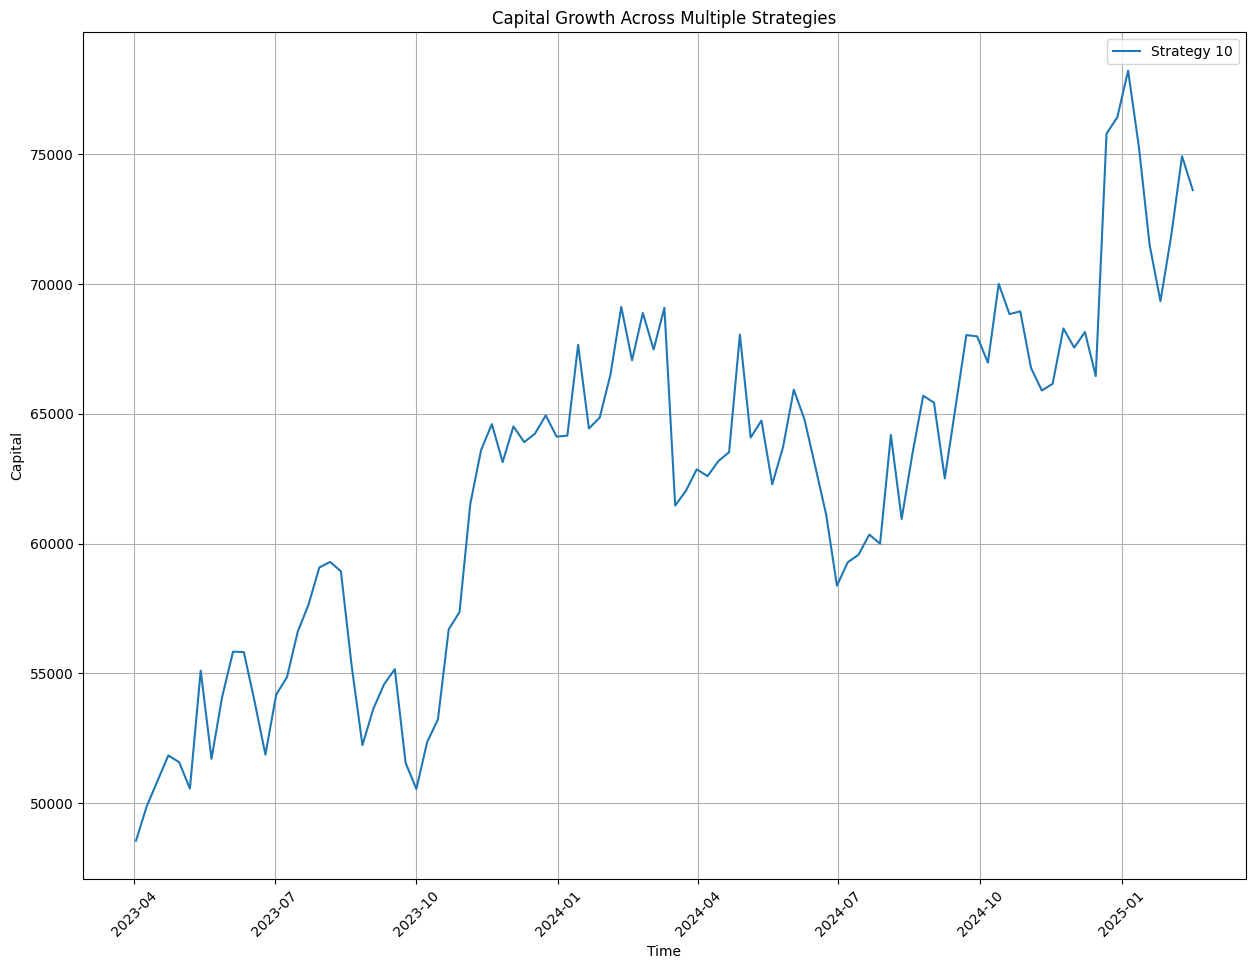

In [3]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+filepath,
                             plotAllDatas=False, dataIdsSelected=[10],
                             plotSize=(15,11))

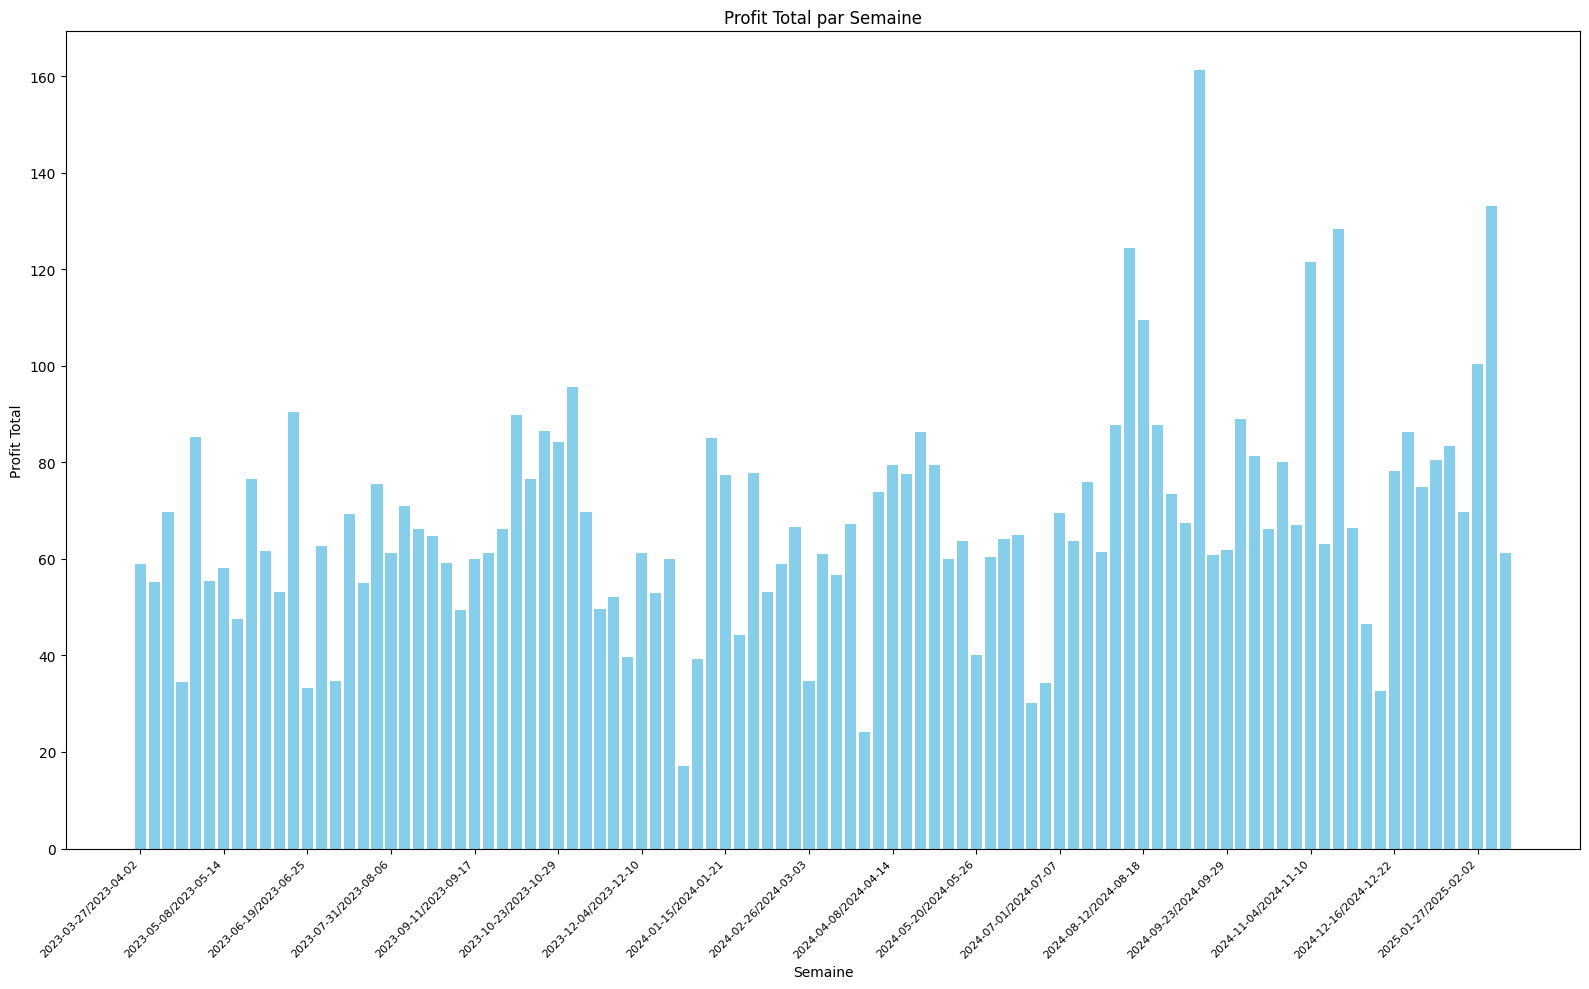

In [3]:
from processing_functions import plot_bars_of_profit_for_every_weeks
plot_bars_of_profit_for_every_weeks(filepath, 32)

Nouvelles choses à tester : 
- condition de sorties supp. si on a un grand doji/marteau/pendu (***) => fait! : résultats mauvais
- rajouter la possibilité de déplacer le TP si le profit continu. Peut etre avec la tenkan ou avec un autre indicateur? l'ATR? (***)
- stop loss suiveur avec tenkan? => méthode 4; retester avec les méthodes et sans slModifers(**) 
- restester sans niveau de pivot (**)
- rajouter une condition sur la taille de la bougie d'entrée = pas de trade si trop grande (**)
- tester d'augmenter la plage horraire de trading <7h ou >20h (**)
- analyser les heures les moins rentables = forbideenHours (**) 
- raffiner les niveaux de slModifiers/sl/tp (*)
- rajouter les niveaux du plus bas/plus haut journalier aux conditions d'entré (*)

choses à faire pour continuer à backtest : (déjà fait)
- avoir le temps moyen d'un trade avec la stratégie DTP : FAIT!
- regarder si le type de position (short ou long) a un impact sur le winrate
- continuer à améliorer la stratégie avec:
    - les autres conditions d'entrées de la strat DTP (ex: taille de la bougie)
    - des conditions sur les niveaux pivot
    - des conditions pour savoir si on est en range
    - faire en sorte que le tp/sl s'adapte à la distance au pivot
- calculer le profit réel en $ : FAIT!
- stop loss suiveur : passe en breakeven sous certaines conditions 
- condition sur l'entré en position avec le RSI : entrer seulement si dans la zone de hausse ou de baisse temperé 
- condition sur la taille de la bougie (bougie trop grande = news). On pourra utiliser les taille moyenne de bougie/H
- utilise l'API pour avoir l'historique des news

méthodes à tester maintenant :
- l'ATR défini notre niveau de TP (tester niveau de TP = atrRatio [2,3,4,5])
- la pente de l'ATR défini si on place un TP définitif, ex : si la pente de l'ATR < X et que prix actuel >= 90% TP initial on ne déplace plus le TP